In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "264_5k_iso"
    npy_file_name_aniso = f"p_iso_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_iso_264_5k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The 264_5k_iso data size is: (76, 264, 264, 264)
READING DATA DONE
The 264_5k_iso energy data size is: (76, 264, 264, 264)
READING ENERGY DATA DONE


In [3]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 5000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix.item())
            else:
                # cores = 128
                # loop_times = 5
                # R = np.zeros((size_x,size_y,size_z,4))
                # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                # smoothing_class.linear3d_main("curvature")
                # C_ln = smoothing_class.get_C()
                # curvature_matrix = C_ln[1,:]
                # curvature_matrix_list.append(curvature_matrix)
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                        GB_infomation_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    
                    # calculate or extract curvature
                    if pair_id not in curvature_matrix: continue
                    GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

100%|██████████| 51/51 [00:00<00:00, 58.75it/s]


In [4]:
    # GB Energy information
    step_num=51
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:00<00:00, 100.24it/s]


In [5]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    def compute_necessary_info_split(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < 100 or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 4058
key num end with 197


100%|██████████| 197/197 [00:00<00:00, 446154.37it/s]

finish 0 with num of GBs 197, and collected num of GBs 91
key num start with 2203
key num end with 1132



100%|██████████| 1132/1132 [00:00<00:00, 556161.66it/s]


finish 1 with num of GBs 1132, and collected num of GBs 404
key num start with 2526
key num end with 1394


100%|██████████| 1394/1394 [00:00<00:00, 606772.50it/s]


finish 2 with num of GBs 1394, and collected num of GBs 725
key num start with 3086
key num end with 1709


100%|██████████| 1709/1709 [00:00<00:00, 658103.70it/s]


finish 3 with num of GBs 1709, and collected num of GBs 1120
key num start with 3536
key num end with 1896


100%|██████████| 1896/1896 [00:00<00:00, 649228.54it/s]


finish 4 with num of GBs 1896, and collected num of GBs 1530
key num start with 3807
key num end with 2046


100%|██████████| 2046/2046 [00:00<00:00, 718301.33it/s]


finish 5 with num of GBs 2046, and collected num of GBs 1921
key num start with 3961
key num end with 2098


100%|██████████| 2098/2098 [00:00<00:00, 690981.53it/s]


finish 6 with num of GBs 2098, and collected num of GBs 2281
key num start with 4007
key num end with 2043


100%|██████████| 2043/2043 [00:00<00:00, 707886.25it/s]


finish 7 with num of GBs 2043, and collected num of GBs 2592
key num start with 3946
key num end with 2039


100%|██████████| 2039/2039 [00:00<00:00, 671919.06it/s]


finish 8 with num of GBs 2039, and collected num of GBs 2869
key num start with 3893
key num end with 1993


100%|██████████| 1993/1993 [00:00<00:00, 756424.57it/s]


finish 9 with num of GBs 1993, and collected num of GBs 3114
key num start with 3800
key num end with 1912


100%|██████████| 1912/1912 [00:00<00:00, 706253.57it/s]


finish 10 with num of GBs 1912, and collected num of GBs 3310
key num start with 3643
key num end with 1807


100%|██████████| 1807/1807 [00:00<00:00, 708327.79it/s]


finish 11 with num of GBs 1807, and collected num of GBs 3497
key num start with 3477
key num end with 1624


100%|██████████| 1624/1624 [00:00<00:00, 670362.14it/s]


finish 12 with num of GBs 1624, and collected num of GBs 3641
key num start with 3283
key num end with 1562


100%|██████████| 1562/1562 [00:00<00:00, 747461.82it/s]


finish 13 with num of GBs 1562, and collected num of GBs 3773
key num start with 3139
key num end with 1464


100%|██████████| 1464/1464 [00:00<00:00, 638567.08it/s]


finish 14 with num of GBs 1464, and collected num of GBs 3898
key num start with 3026
key num end with 1390


100%|██████████| 1390/1390 [00:00<00:00, 618839.04it/s]


finish 15 with num of GBs 1390, and collected num of GBs 4015
key num start with 2880
key num end with 1330


100%|██████████| 1330/1330 [00:00<00:00, 643936.78it/s]


finish 16 with num of GBs 1330, and collected num of GBs 4108
key num start with 2765
key num end with 1284


100%|██████████| 1284/1284 [00:00<00:00, 638847.73it/s]


finish 17 with num of GBs 1284, and collected num of GBs 4222
key num start with 2644
key num end with 1167


100%|██████████| 1167/1167 [00:00<00:00, 708152.89it/s]


finish 18 with num of GBs 1167, and collected num of GBs 4292
key num start with 2544
key num end with 1108


100%|██████████| 1108/1108 [00:00<00:00, 543415.44it/s]


finish 19 with num of GBs 1108, and collected num of GBs 4362
key num start with 2405
key num end with 1025


100%|██████████| 1025/1025 [00:00<00:00, 684470.88it/s]


finish 20 with num of GBs 1025, and collected num of GBs 4435
key num start with 2285
key num end with 948


100%|██████████| 948/948 [00:00<00:00, 590905.07it/s]


finish 21 with num of GBs 948, and collected num of GBs 4506
key num start with 2184
key num end with 912


100%|██████████| 912/912 [00:00<00:00, 685397.82it/s]

finish 22 with num of GBs 912, and collected num of GBs 4556
key num start with 2113
key num end with 886



100%|██████████| 886/886 [00:00<00:00, 669939.31it/s]


finish 23 with num of GBs 886, and collected num of GBs 4612
key num start with 2044
key num end with 822


100%|██████████| 822/822 [00:00<00:00, 387210.01it/s]


finish 24 with num of GBs 822, and collected num of GBs 4654
key num start with 1972
key num end with 819


100%|██████████| 819/819 [00:00<00:00, 402523.43it/s]


finish 25 with num of GBs 819, and collected num of GBs 4691
key num start with 1901
key num end with 767


100%|██████████| 767/767 [00:00<00:00, 596298.64it/s]


finish 26 with num of GBs 767, and collected num of GBs 4725
key num start with 1822
key num end with 750


100%|██████████| 750/750 [00:00<00:00, 694114.74it/s]


finish 27 with num of GBs 750, and collected num of GBs 4761
key num start with 1745
key num end with 656


100%|██████████| 656/656 [00:00<00:00, 730800.38it/s]


finish 28 with num of GBs 656, and collected num of GBs 4795
key num start with 1687
key num end with 623


100%|██████████| 623/623 [00:00<00:00, 722835.79it/s]


finish 29 with num of GBs 623, and collected num of GBs 4828
key num start with 1628
key num end with 640


100%|██████████| 640/640 [00:00<00:00, 733630.65it/s]

finish 30 with num of GBs 640, and collected num of GBs 4852
key num start with 1598
key num end with 628



100%|██████████| 628/628 [00:00<00:00, 585468.53it/s]


finish 31 with num of GBs 628, and collected num of GBs 4895
key num start with 1546
key num end with 590


100%|██████████| 590/590 [00:00<00:00, 759324.75it/s]

finish 32 with num of GBs 590, and collected num of GBs 4921
key num start with 1485
key num end with 543



100%|██████████| 543/543 [00:00<00:00, 679447.22it/s]


finish 33 with num of GBs 543, and collected num of GBs 4943
key num start with 1440
key num end with 536


100%|██████████| 536/536 [00:00<00:00, 754664.97it/s]

finish 34 with num of GBs 536, and collected num of GBs 4963
key num start with 1390
key num end with 501



100%|██████████| 501/501 [00:00<00:00, 739650.23it/s]


finish 35 with num of GBs 501, and collected num of GBs 4979
key num start with 1338
key num end with 482


100%|██████████| 482/482 [00:00<00:00, 755194.07it/s]

finish 36 with num of GBs 482, and collected num of GBs 4988
key num start with 1302
key num end with 474



100%|██████████| 474/474 [00:00<00:00, 580976.07it/s]


finish 37 with num of GBs 474, and collected num of GBs 5007
key num start with 1250
key num end with 449


100%|██████████| 449/449 [00:00<00:00, 661250.88it/s]


finish 38 with num of GBs 449, and collected num of GBs 5020
key num start with 1204
key num end with 422


100%|██████████| 422/422 [00:00<00:00, 731101.32it/s]


finish 39 with num of GBs 422, and collected num of GBs 5036
key num start with 1154
key num end with 411


100%|██████████| 411/411 [00:00<00:00, 702469.01it/s]


finish 40 with num of GBs 411, and collected num of GBs 5059
key num start with 1125
key num end with 409


100%|██████████| 409/409 [00:00<00:00, 699906.30it/s]

finish 41 with num of GBs 409, and collected num of GBs 5070
key num start with 1092
key num end with 377



100%|██████████| 377/377 [00:00<00:00, 749764.16it/s]


finish 42 with num of GBs 377, and collected num of GBs 5079
key num start with 1052
key num end with 349


100%|██████████| 349/349 [00:00<00:00, 662358.41it/s]


finish 43 with num of GBs 349, and collected num of GBs 5092
key num start with 1011
key num end with 349


100%|██████████| 349/349 [00:00<00:00, 572248.67it/s]


finish 44 with num of GBs 349, and collected num of GBs 5100
key num start with 987
key num end with 332


100%|██████████| 332/332 [00:00<00:00, 320190.60it/s]

finish 45 with num of GBs 332, and collected num of GBs 5113
key num start with 954
key num end with 311



100%|██████████| 311/311 [00:00<00:00, 697555.37it/s]


finish 46 with num of GBs 311, and collected num of GBs 5124
key num start with 927
key num end with 289


100%|██████████| 289/289 [00:00<00:00, 692263.77it/s]


finish 47 with num of GBs 289, and collected num of GBs 5134
key num start with 903
key num end with 301


100%|██████████| 301/301 [00:00<00:00, 627789.91it/s]


finish 48 with num of GBs 301, and collected num of GBs 5134
key num start with 873
key num end with 268


100%|██████████| 268/268 [00:00<00:00, 671088.64it/s]

finish 49 with num of GBs 268, and collected num of GBs 5134


In [6]:
len(GB_id_focus_copy)

5134

In [7]:
    time_interval = 2
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    for time_step in tqdm(range(step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
            
        
            

100%|██████████| 51/51 [00:00<00:00, 296.48it/s]


In [8]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    # print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 1493
The ratio of anti-curvature GBs during whole simulations is 11.341537526587665% in 13164 GBs


In [9]:
    total_GB = set()
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)

    anti_c_num = 0
    for key in GB_id_focus:
        anti_c_num += GB_id_focus[key]
    print(f"The number of the GBs showing anti-curvature during whole simulations is {anti_c_num}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {anti_c_num/total_GB_num*100}% in {total_GB_num} GBs")
    
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    for i in range(0,len(GB_list_curvature_list)): 
        for j in range(len(GB_list_curvature_list[i])):
            # in general, curvature>0, V_d1 is the voxel in curvature direction, while V_d1 is anti-c when curvature<0
            if GB_list_curvature_list[i][j]<0: 
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j]>=0: 
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} GBs")
    
    

The number of the GBs showing anti-curvature during whole simulations is 3696
The ratio of anti-curvature GBs during whole simulations is 3.314649567283978% in 111505 GBs
The number of the normal voxels and antic voxels during whole simulations are 12752972 and 1805053
The ratio of anti-curvature voxels during whole simulations is 12.399023906058686% in 14558025 GBs


<Figure size 432x288 with 0 Axes>

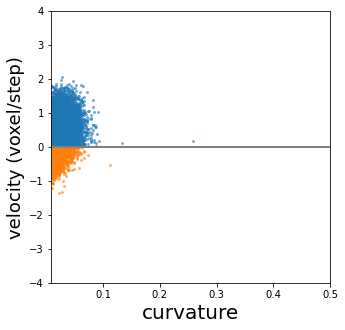

<Figure size 432x288 with 0 Axes>

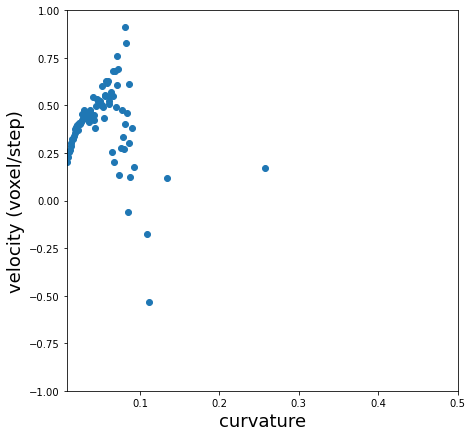

In [10]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    area_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
        area_1Dlist_remove_0step.extend(GB_list_area_list[i])
    
    # ignore the sign of curvature for all GBs list
    for i in range(len(curvature_1Dlist_remove_0step)):
        if curvature_1Dlist_remove_0step[i]<0: 
            curvature_1Dlist_remove_0step[i] = - curvature_1Dlist_remove_0step[i]
            velocity_1Dlist_remove_0step[i] = - velocity_1Dlist_remove_0step[i]
    velocity_1Dlist_remove_0step = np.array(velocity_1Dlist_remove_0step)
    curvature_1Dlist_remove_0step = np.array(curvature_1Dlist_remove_0step)
    area_1Dlist_remove_0step = np.array(area_1Dlist_remove_0step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0],s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_remove_0step)):
        if abs(curvature_1Dlist_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


Text(0, 0.5, 'area')

<Figure size 432x288 with 0 Axes>

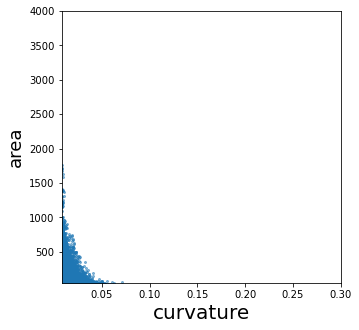

<Figure size 432x288 with 0 Axes>

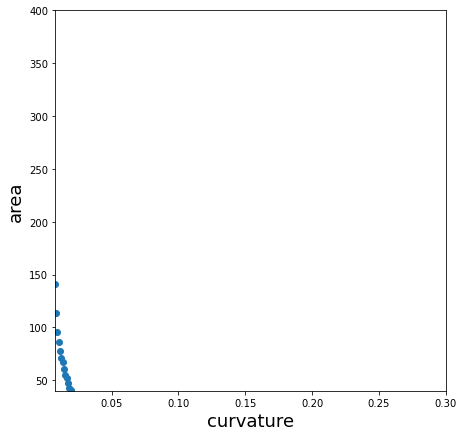

In [15]:
    # curvature VS area
    figure_name_all = f"figures/3D_signedcurvature_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.3],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_remove_0step, area_1Dlist_remove_0step,s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step<0],s=4,alpha=0.5,color='C01')
    # plt.scatter(GB_antic_list_curvature_list, GB_antic_list_area_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("area", fontsize=18)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([50,4000])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot average
    bin_interval = 0.001
    x_lim = [0.0,0.3]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    area_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_remove_0step)):
        if abs(curvature_1Dlist_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        area_bin[int((curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += area_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: area_bin[i] = area_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_signedcurvature_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([curvature_limit,0.30])
    plt.ylim([40,400])
    plt.plot(curvature_coordinate[area_bin!=0], area_bin[area_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("area", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

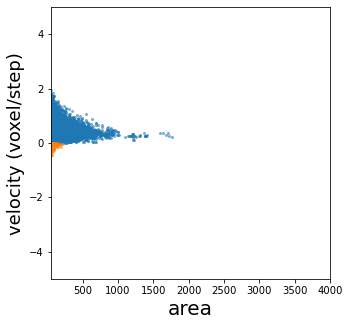

<Figure size 432x288 with 0 Axes>

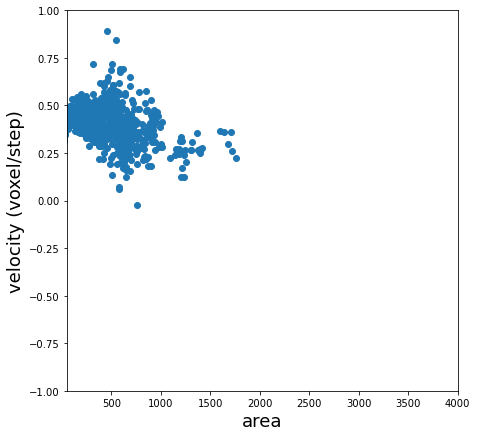

In [16]:
    # area VS velocity
    figure_name_all = f"figures/3D_velocity_area_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.scatter(area_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0], velocity_1Dlist_remove_0step[velocity_1Dlist_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(GB_antic_list_area_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("area", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([50,4000])
    plt.ylim([-5,5])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged area
    bin_interval = 1
    x_lim = [0.0,6000]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    area_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    area_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(area_1Dlist_remove_0step)):
        if abs(area_1Dlist_remove_0step[index])>x_lim[1]: continue
        area_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((area_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if area_bin[i]>0: velocity_bin[i] = velocity_bin[i]/area_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_area_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,4000])
    plt.ylim([-1,1])
    plt.plot(area_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

average area is 58.61738515312916


<Figure size 432x288 with 0 Axes>

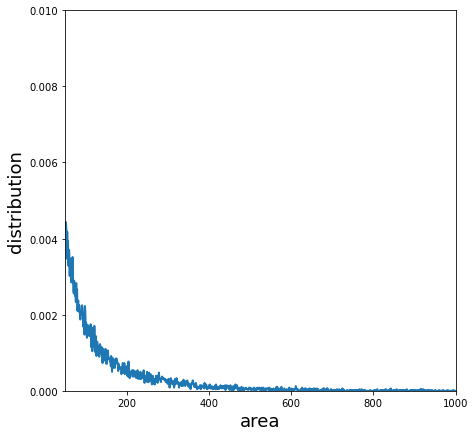

<Figure size 432x288 with 0 Axes>

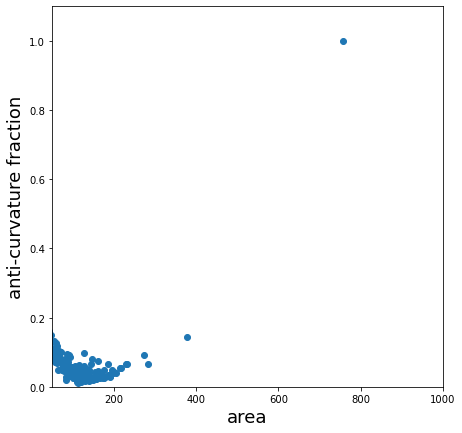

In [17]:
    # anti-c fraction VS area bin
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,1000])
    plt.ylim([0,0.01])
    plt.plot(area_coordinate, area_bin/np.sum(area_bin),'-', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(area_bin)):
        if area_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/area_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([50,1000])
    plt.ylim([0,1.1])
    plt.plot(area_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("area", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    print(f"average area is {np.mean(area_1Dlist_remove_0step)}")

In [18]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-2,2])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


NameError: name 'GBenergy_1Dlist_exrandom_remove_0step' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/3D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        x_lim = [0.0,0.1]
        bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
        curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>x_lim[1]: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]-x_lim[0])//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/3D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')